In [4]:
!pip install madgrad
!pip install git+https://github.com/openai/CLIP.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for madgrad: filename=madgrad-1.3-py3-none-any.whl size=11868 sha256=b6b36de718e98805e1fec78ef80a4f39681e9bc0ba635b653d7cc4d2cbce17b0
  Stored in directory: /root/.cache/pip/wheels/d9/a3/83/7ed1ddc517cd87cad4e3a4aec7f8ea1d5e83a5ff282e51490a
Successfully built madgrad
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-78b8rkmw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-78b8rkmw
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.6 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=f0eef0ba0cc9a5f86dcaa69c8e9410a74a5cafc9d53775c52bc79ff826809193
  Stored in directory: /t

In [5]:
import json
import os
from collections import Counter
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
from tqdm.notebook import tqdm
from transformers import (
    AutoConfig,
    AutoModel,
    AutoTokenizer,
    MMBTConfig,
    MMBTForClassification,
    get_linear_schedule_with_warmup,
)
from madgrad import MADGRAD
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
import clip
import pickle
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import copy

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [8]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [9]:
clip_model, preprocess = clip.load("RN50x4", device=device, jit=False)

100%|███████████████████████████████████████| 402M/402M [00:42<00:00, 10.0MiB/s]


In [10]:
for p in clip_model.parameters():
    p.requires_grad = False

In [34]:
# Model parameters
image_embed_count = 1
gradient_accumulation_steps = 20
max_seq_length = 80 
max_grad_norm = 0.5
batch_size = 16
image_encoder_size = 288
image_features_size = 640
num_epochs = 10

In [35]:
def preprocess_img_clip(image, desired_size):
    old_size = image.size  
    ratio = float(desired_size) / max(old_size)
    new_size = tuple([int(x * ratio) for x in old_size])
    
    image = image.resize(new_size, Image.ANTIALIAS)
    
    new_image = Image.new("RGB", (desired_size, desired_size))
    new_image.paste(image, ((desired_size-new_size[0])//2, (desired_size-new_size[1])//2))
    
    return new_image

In [51]:
class ClipEncoder(nn.Module):
    def __init__(self, num_embeds, num_features=image_features_size):
        super().__init__()        
        self.model = clip_model
        self.num_embeds = num_embeds
        self.num_features = num_features

    def forward(self, x):
        out = self.model.encode_image(x.view(-1, 3, 288, 288))
        out = out.view(-1, self.num_embeds, self.num_features).float()
        return out

In [52]:
class DatasetFromPaths(Dataset):
    def __init__(self, data_paths, tokenizer, transforms, max_seq_length):
        self.data = []
        for data_path in data_paths:
            self.data.extend([json.loads(l) for l in open(data_path)])
        self.data_dir = os.path.dirname(data_paths[0])
        self.tokenizer = tokenizer
        self.max_seq_length = max_seq_length
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sentence = torch.LongTensor(self.tokenizer.encode(self.data[index]["text"], add_special_tokens=True))
        start_token, sentence, end_token = sentence[0], sentence[1:-1], sentence[-1]
        sentence = sentence[:self.max_seq_length]
        
        label = torch.FloatTensor([self.data[index]["label"]])
        
        image = Image.open(os.path.join(self.data_dir, self.data[index]["img"])).convert("RGB")
        image = preprocess_img_clip(image, image_encoder_size)
        image = np.array(self.transforms(image))
        
        images = [image]
        images = torch.from_numpy(np.array(images)).to(device)

        return {
            "image_start_token": start_token,
            "image_end_token": end_token,
            "sentence": sentence,
            "image": images,
            "label": label
        }


In [53]:
def collate_fn(batch):
    lengths = [len(row["sentence"]) for row in batch]
    batch_size, max_seq_len = len(batch), max(lengths)
    
    mask_tensor = torch.zeros(batch_size, max_seq_len, dtype=torch.long)
    text_tensor = torch.zeros(batch_size, max_seq_len, dtype=torch.long)
    
    for i_batch, (input_row, length) in enumerate(zip(batch, lengths)):
        text_tensor[i_batch, :length] = input_row["sentence"]
        mask_tensor[i_batch, :length] = 1
    
    image_tensor = torch.stack([row["image"] for row in batch])
    label_tensor = torch.stack([row["label"] for row in batch])
    
    image_start_token = torch.stack([row["image_start_token"] for row in batch])
    image_end_token = torch.stack([row["image_end_token"] for row in batch])
    
    return text_tensor, mask_tensor, image_tensor, image_start_token, image_end_token, label_tensor

In [54]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)

In [55]:
input_path = "/kaggle/input/facebook-hateful-memes/hateful_memes/"

In [56]:
train_dataset = DatasetFromPaths([os.path.join(input_path, "train.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count - 2)
val_dataset = DatasetFromPaths([os.path.join(input_path, "dev_seen.jsonl"), os.path.join(input_path, "dev_unseen.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count - 2)

In [57]:
train_sampler = RandomSampler(train_dataset)
val_sampler = SequentialSampler(val_dataset)

train_dataloader = DataLoader(
        train_dataset,
        sampler=train_sampler,
        batch_size=batch_size,
        collate_fn=collate_fn
    )

val_dataloader = DataLoader(
        val_dataset, 
        sampler=val_sampler, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )

In [58]:
# Load model config and initialize model
transformer_config = AutoConfig.from_pretrained(model_name) 
transformer = AutoModel.from_pretrained(model_name, config=transformer_config)
img_encoder = ClipEncoder(image_embed_count)
config = MMBTConfig(transformer_config, num_labels=1, modal_hidden_size=image_features_size)
model = MMBTForClassification(config, transformer, img_encoder).to(device)

In [61]:
no_decay = ["bias", 
            "LayerNorm.weight"
           ]
weight_decay = 0.0005
optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], "weight_decay": weight_decay},
    {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
]
optimizer = MADGRAD(optimizer_grouped_parameters, lr=2e-4)

t_total = (len(train_dataloader) // gradient_accumulation_steps) * num_epochs
warmup_steps = t_total // 10

scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, t_total)
criterion = nn.BCEWithLogitsLoss()

In [62]:
model_path ="/kaggle/working/models/"

In [63]:
!mkdir -p models

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [64]:
def save_model(save_path, model, valid_loss):
    if save_path == None:
        return
    state_dict = {'state_dict': model.state_dict(),
                  'valid_loss': valid_loss}
    torch.save(state_dict, save_path)
    print('Model saved!')

In [65]:
def evaluate(model, tokenizer, criterion, dataloader, tres = 0.5): 
    val_loss = 0.0
    val_steps = 0
    predictions = None
    probabilities = None
    output_labels = None
    
    for batch in dataloader:
        model.eval()
        batch = tuple(t.to(device) for t in batch)
        
        with torch.no_grad():
            labels = batch[5]
            inputs = {
                "input_ids": batch[0],
                "input_modal": batch[2],
                "attention_mask": batch[1],
                "modal_start_tokens": batch[3],
                "modal_end_tokens": batch[4],
                "return_dict": False
            }
            outputs = model(**inputs)
            logits = outputs[0]
            
            temp_val_loss = criterion(logits, labels)
            val_loss += temp_val_loss.mean().item()
        
        val_steps += 1
        
        if predictions is None:
            predictions = torch.sigmoid(logits).detach().cpu().numpy() > tres
            probabilities = torch.sigmoid(logits).detach().cpu().numpy()
            output_labels = labels.detach().cpu().numpy()
        else:            
            predictions = np.append(predictions, torch.sigmoid(logits).detach().cpu().numpy() > tres, axis=0)
            probabilities = np.append(probabilities, torch.sigmoid(logits).detach().cpu().numpy(), axis=0)
            output_labels = np.append(output_labels, labels.detach().cpu().numpy(), axis=0)
    
    val_loss = val_loss / val_steps

    result = {
        "loss": val_loss,
        "accuracy": accuracy_score(output_labels, predictions),
        "AUC": roc_auc_score(output_labels, probabilities),
        "micro_f1": f1_score(output_labels, predictions, average="micro"),
        "prediction": predictions,
        "labels": output_labels,
        "probabilities": probabilities
    }
    
    return result

# Training

In [66]:
total_steps = 0
train_loss = 0.0
min_needed_valid_auc = 0.65
steps_list = []
train_loss_list = []
val_loss_list = []
val_acc_list = []
val_auc_list = []
val_every = len(train_dataloader) // 7
cummulative_step_loss = 0

for i in range(num_epochs):
    for step, batch in enumerate(tqdm(train_dataloader)):
        model.train()
        batch = tuple(t.to(device) for t in batch)
        labels = batch[5]
        inputs = {
            "input_ids": batch[0],
            "input_modal": batch[2],
            "attention_mask": batch[1],
            "modal_start_tokens": batch[3],
            "modal_end_tokens": batch[4],
            "return_dict": False
        }
        outputs = model(**inputs)
        logits = outputs[0]
        loss = criterion(logits, labels)
        
        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps
        
        loss.backward()
        train_loss += loss.item()
        cummulative_step_loss += loss.item()
        total_steps += 1
        
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        
        if (step + 1) % val_every == 0:
            average_train_loss = cummulative_step_loss / val_every
            train_loss_list.append(average_train_loss)
            steps_list.append(total_steps)
            cummulative_step_loss = 0.0  
            
            val_result = evaluate(model, tokenizer, criterion, val_dataloader)
            val_loss_list.append(val_result['loss'])
            val_acc_list.append(val_result['accuracy'])
            val_auc_list.append(val_result['AUC'])
            
            if val_result['AUC'] > min_needed_valid_auc:
                min_needed_valid_auc = val_result['AUC']
                val_loss = val_result['loss']
                val_acc = val_result['accuracy']
                model_path = f'{model_path}/model-embs{image_embed_count}-seq{max_seq_length}-auc{min_needed_valid_auc:.3f}-loss{val_loss:.3f}-acc{val_acc:.3f}.pt'
                print(f"AUC improved, so saving this model")  
                save_model(model_path, model, val_result['loss'])            
            print("Train loss:", f"{average_train_loss:.4f}", 
                  "Val loss:", f"{val_result['loss']:.4f}",
                  "Val acc:", f"{val_result['accuracy']:.4f}",
                  "AUC:", f"{val_result['AUC']:.4f}")

  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0371 Val loss: 0.7119 Val acc: 0.4298 AUC: 0.4993


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0351 Val loss: 0.6878 Val acc: 0.5615 AUC: 0.4842


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0332 Val loss: 0.7026 Val acc: 0.5702 AUC: 0.5009


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0324 Val loss: 0.6806 Val acc: 0.5731 AUC: 0.5774


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0316 Val loss: 0.6975 Val acc: 0.5779 AUC: 0.5850


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0305 Val loss: 0.6988 Val acc: 0.5865 AUC: 0.5924


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0301 Val loss: 0.7023 Val acc: 0.5875 AUC: 0.5880


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0273 Val loss: 0.7191 Val acc: 0.5798 AUC: 0.6030


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0258 Val loss: 0.8385 Val acc: 0.5865 AUC: 0.6160


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0279 Val loss: 0.7312 Val acc: 0.6038 AUC: 0.6155


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0267 Val loss: 0.7096 Val acc: 0.6125 AUC: 0.6232


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0254 Val loss: 0.7134 Val acc: 0.6135 AUC: 0.6367


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0258 Val loss: 0.9210 Val acc: 0.5846 AUC: 0.6470


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0273 Val loss: 0.6904 Val acc: 0.6183 AUC: 0.6510


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0228 Val loss: 0.7562 Val acc: 0.6067 AUC: 0.6556


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0230 Val loss: 0.9028 Val acc: 0.6029 AUC: 0.6468


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0212 Val loss: 0.7044 Val acc: 0.6288 AUC: 0.6637


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0215 Val loss: 0.7346 Val acc: 0.6260 AUC: 0.6646


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0210 Val loss: 0.7855 Val acc: 0.6240 AUC: 0.6634


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0235 Val loss: 0.6936 Val acc: 0.6221 AUC: 0.6722


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0219 Val loss: 0.7418 Val acc: 0.6298 AUC: 0.6717


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0191 Val loss: 0.8030 Val acc: 0.6567 AUC: 0.6791


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0197 Val loss: 0.7749 Val acc: 0.6385 AUC: 0.6827


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0190 Val loss: 0.9529 Val acc: 0.6077 AUC: 0.6726


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0213 Val loss: 0.7988 Val acc: 0.6567 AUC: 0.6874


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0217 Val loss: 0.7435 Val acc: 0.6519 AUC: 0.6958


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0172 Val loss: 0.8466 Val acc: 0.6163 AUC: 0.6975


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0185 Val loss: 0.7021 Val acc: 0.6490 AUC: 0.7087


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0165 Val loss: 0.9399 Val acc: 0.6212 AUC: 0.6987


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0144 Val loss: 0.8597 Val acc: 0.6644 AUC: 0.6987


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0155 Val loss: 0.8512 Val acc: 0.6510 AUC: 0.6973


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0144 Val loss: 0.9092 Val acc: 0.6442 AUC: 0.6975


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0147 Val loss: 0.9845 Val acc: 0.6231 AUC: 0.6975


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0186 Val loss: 0.7669 Val acc: 0.6500 AUC: 0.6993


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0163 Val loss: 0.7302 Val acc: 0.6423 AUC: 0.7007


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0131 Val loss: 0.9705 Val acc: 0.6356 AUC: 0.7007


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0125 Val loss: 1.0378 Val acc: 0.6442 AUC: 0.7062


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0124 Val loss: 0.9413 Val acc: 0.6452 AUC: 0.7113


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0075 Val loss: 1.2598 Val acc: 0.6567 AUC: 0.6973


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0085 Val loss: 1.1141 Val acc: 0.6567 AUC: 0.7122


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0091 Val loss: 1.3084 Val acc: 0.6433 AUC: 0.7019


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0085 Val loss: 0.9861 Val acc: 0.6596 AUC: 0.7211


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0079 Val loss: 1.0625 Val acc: 0.6519 AUC: 0.7198


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0051 Val loss: 1.1021 Val acc: 0.6596 AUC: 0.7116


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0063 Val loss: 1.1826 Val acc: 0.6548 AUC: 0.7086


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0070 Val loss: 1.4211 Val acc: 0.6462 AUC: 0.6998


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0068 Val loss: 1.2279 Val acc: 0.6644 AUC: 0.7136


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0062 Val loss: 1.4040 Val acc: 0.6500 AUC: 0.7055


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0048 Val loss: 1.1895 Val acc: 0.6760 AUC: 0.7264


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0067 Val loss: 1.3060 Val acc: 0.6567 AUC: 0.7196


  0%|          | 0/532 [00:00<?, ?it/s]

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0040 Val loss: 1.4168 Val acc: 0.6442 AUC: 0.7139


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0045 Val loss: 1.1935 Val acc: 0.6750 AUC: 0.7289


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0041 Val loss: 1.3086 Val acc: 0.6606 AUC: 0.7152


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0054 Val loss: 1.4115 Val acc: 0.6577 AUC: 0.7088


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0049 Val loss: 1.2774 Val acc: 0.6587 AUC: 0.7150


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0047 Val loss: 1.2346 Val acc: 0.6538 AUC: 0.7213


/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Train loss: 0.0046 Val loss: 1.2734 Val acc: 0.6548 AUC: 0.7156


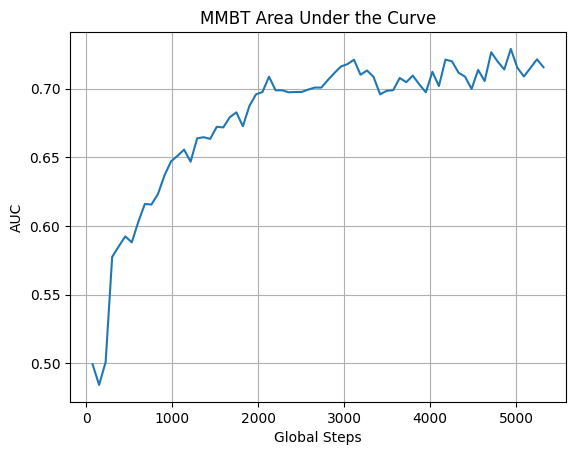

In [67]:
plt.plot(steps_list, val_auc_list)
plt.grid()
plt.xlabel('Global Steps')
plt.ylabel('AUC')
plt.title('MMBT Area Under the Curve')
plt.show() 

# Testing

In [69]:
test_seen_dataset = DatasetFromPaths([os.path.join(input_path, "test_seen.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count - 2)
test_unseen_dataset = DatasetFromPaths([os.path.join(input_path, "test_unseen.jsonl")], tokenizer, preprocess, max_seq_length - image_embed_count - 2)

In [70]:
test_seen_sampler = SequentialSampler(test_seen_dataset)
test_unseen_sampler = SequentialSampler(test_unseen_dataset)

test_seen_dataloader = DataLoader(
        test_seen_dataset, 
        sampler=test_seen_sampler, 
        batch_size=batch_size, 
        collate_fn=collate_fn
    )

test_unseen_dataloader = DataLoader(
        test_unseen_dataset, 
        sampler=test_unseen_sampler,
        batch_size=batch_size, 
        collate_fn=collate_fn
    )

In [74]:
test_seen_result = evaluate(model, tokenizer, criterion, test_seen_dataloader)
print("Test Seen loss:", f"{test_seen_result['loss']:.4f}", 
                  "Test Seen accuracy:", f"{test_seen_result['accuracy']:.4f}",
                  "Test Seen AUC:", f"{test_seen_result['AUC']:.4f}")

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Test Seen loss: 1.2010 Test Seen accuracy: 0.6790 Test Seen AUC: 0.7751


In [75]:
test_unseen_result = evaluate(model, tokenizer, criterion, test_unseen_dataloader)
print("Test Unseen loss:", f"{test_unseen_result['loss']:.4f}", 
                  "Test Unseen accuracy:", f"{test_unseen_result['accuracy']:.4f}",
                  "Test Unseen AUC:", f"{test_unseen_result['AUC']:.4f}")

/tmp/ipykernel_34/769041205.py:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  im = im.resize(new_size, Image.ANTIALIAS)


Test Unseen loss: 1.0778 Test Unseen accuracy: 0.7085 Test Unseen AUC: 0.7501
